# computing error of linear particle annihilation rate to that of the full models (gpu-accelerated)
Tim Tyree<br>
9.12..2022

In [1]:
from lib.my_initialization import *
from lib import *
#from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
from scipy.optimize import minimize
#load libraries for color bar
import matplotlib as mpl #for colorbar
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
#def plotter_3dpoint_cloud_sample(az,...):
from scipy import stats
#DONE: hook this routine up to dask
#DONT: hook this routine up to dask_cuda
# import scanpy as sc
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
#     theme=cuxfilter.themes.dark
#     #     theme=cuxfilter.themes.rapids
else:
    sns.set_style('white')
#     theme=cuxfilter.themes.light
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2
# import cupy as cp
np.random.seed(42)
# cp.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
#reset matplotlib settings
from mpltools import annotation
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# define module

In [4]:
def routine_measure_annihilation_error_function_linear_to_full(input_folder,max_num_jobs=8,
        printing=True,testing=True,**kwargs):
    """
    Example Usage:
input_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
df_defects_fk,df_defects_lr = routine_measure_annihilation_error_function_linear_to_full(input_folder=input_folder,max_num_jobs=8,printing=True,testing=True)#,**kwargs)
    """
    os.chdir(input_folder)
    task_lst = [os.path.abspath(input_fn) for input_fn in os.listdir()]
    if printing:
        print(f"{input_folder=}")
        print(f"added {len(task_lst)} tasks to queue!")

    def routine_(task):
        try:
            input_fn = task
            df,dict_linear = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
            if dict_linear is None:
                return None
            #dict_linear['folder'] = os.path.basename(input_fn) #strings are relatively expensive at these scales...
            dict_defects_fk,dict_defects_lr = parse_dict_linear_to_row(dic = dict_linear)
            return dict_defects_fk,dict_defects_lr
        except Exception as e:
            return f"Warning: {e} for {task=}"

    if testing:
        input_fn = task_lst[0]
        df,dict_linear = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
        if printing:
            print(f"computed defect for mean annihilation rates of {dict_linear['job_index']=} in {dict_linear['cluster_index']=}:")
            col_lst=['varkappa','D','r','kappa','L']
            for col in col_lst:
                val=df[col].min()
                print(f"{col}: {val}")
            print(F"{df.shape=}")
            print(f"\nkeys available in dict_linear:")
            print(*dict_linear)
            print(f"apparent defects/errors:")
            print(f"rmse_fk: {dict_linear['dict_defects_fk']['rmse']:.4f}")
            print(f"loglik_fk: {dict_linear['dict_defects_fk']['log_likelihood']:.4f}")
            print(f"rmse_lr: {dict_linear['dict_defects_lr']['rmse']:.4f}")
            print(f"loglik_lr: {dict_linear['dict_defects_lr']['log_likelihood']:.4f}")

    #save the defects as a complicated hierarchical dataset
    #optionally, run daskbag
    os.chdir(nb_dir)
    npartitions=np.min((len(task_lst),max_num_jobs))
    # if use_generate_annihilation_defect_table:
    if printing:
        print(f"running {len(task_lst)} tasks over {npartitions} cpu cores (140775 tasks over 4 cpu cores took <9.5?? minutes)...")
    retval=eval_routine_daskbag(routine_,task_lst,npartitions,printing=printing)
    if printing:
        print(f"tasks complete!")

    #format results
    dict_defects_fk_lst=[]
    dict_defects_lr_lst=[]
    for rv in retval:
        if type(rv)==type(''):
            print(rv)
        elif rv is not None:
            dict_defects_fk,dict_defects_lr = rv
            dict_defects_fk_lst.append(dict_defects_fk)
            dict_defects_lr_lst.append(dict_defects_lr)
    df_defects_fk = pd.DataFrame(dict_defects_fk_lst)
    df_defects_lr = pd.DataFrame(dict_defects_lr_lst)
    return df_defects_fk,df_defects_lr


# evaluate measurement routine

__log-likliehood for linear regression:__

$$
L(b_0,b_1,s^2) = \log \Pi_{i=1}^n p(y_i | x_i; b_0,b_1,s^2)
$$
$$...$$
$$
L(b_0,b_1,s^2) = -\frac{n}{2}\log 2\pi - n\log s -\frac{1}{2s^2}\sum_{i=1}^n(y_i - (b_0 +b_1x_i))^2
$$
maximum likelihood estimate of s is the root mean squared error, (RMSE). <br> src: `\https://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/06/lecture-06.pdf/`.

- DONE: use it over dask with 100 tasks
- DONE: use it over dask with 1000 tasks
- DONE: use it over dask with all available tasks

In [5]:
max_num_jobs=8
printing=True
saving=True

In [19]:
#estimated runtime = 1.25 hours for 
output_dir_fk_lst=[]
output_dir_lr_lst=[]
# for run_num in reversed(range(27)):
for run_num in [28]:
    #compute the defects
    input_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
    df_defects_fk,df_defects_lr = routine_measure_annihilation_error_function_linear_to_full(input_folder=input_folder,max_num_jobs=max_num_jobs,printing=False,testing=False)#,**kwargs)
    #save loss measurements as .parquet <15 MB per full model
    if saving:
        parquet_dir_defects_fk=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
        df_defects_fk.to_parquet(parquet_dir_defects_fk)
        parquet_dir_defects_lr=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
        df_defects_lr.to_parquet(parquet_dir_defects_lr)
        print(f"{parquet_dir_defects_fk=}")
        print(f"{parquet_dir_defects_lr=}")
    #record
    output_dir_fk_lst.append(parquet_dir_defects_fk)
    output_dir_lr_lst.append(parquet_dir_defects_lr)
    

parquet_dir_defects_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_28_defects_to_fk.parquet'
parquet_dir_defects_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_28_defects_to_lr.parquet'


In [20]:
len(output_dir_fk_lst)

1

# visualize best settings by $a_{max}$ for one data run:

In [34]:
# run_num=12
# run_num=17
# run_num=18 #best so far
# run_num=19
# run_num=20
# run_num=21
# run_num=22
# run_num=23
# run_num=24
# run_num=25  #good for both
# run_num=26  #
run_num=27  # ??
run_num=28  # ??

# parquet_dir_defects_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_defects_to_fk.parquet'
# parquet_dir_defects_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_defects_to_lr.parquet'
parquet_dir_defects_fk=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
parquet_dir_defects_lr=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
df_defects_fk=pd.read_parquet(parquet_dir_defects_fk)
df_defects_lr=pd.read_parquet(parquet_dir_defects_lr)
df_defects_lr.shape

#compute for each member a=amax-2*D
num_digits_round=2
#add columns for amax
df_defects_fk['amax'] = np.around(df_defects_fk['varkappa'] + 2.*df_defects_fk['D'],num_digits_round)
df_defects_lr['amax'] = np.around(df_defects_lr['varkappa'] + 2.*df_defects_lr['D'],num_digits_round)

print(f"parameter range supported in run #{run_num}:")
print(df_defects_lr.describe()[['r','kappa','D','varkappa','amax','L']].T[['min','max','count']].T)

#identify the lowest error simulation for each amax value
print(f"\n*******************************")
print(f"* Fenton-Karma Model (best settings):")
print(f"*******************************")
minrmse=9999.
for amax,g in df_defects_fk.groupby(by='amax'):
    rmse_min = g['rmse'].min()
    count = g['rmse'].count()
    log_likelihood = g['log_likelihood'].max()
    if rmse_min<=minrmse:
        minrmse=rmse_min
        print(f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}")
    

#identify the lowest error simulation for each amax value
print(f"\n*******************************")
print(f"* Luo-Rudy Model (best settings):")
print(f"*******************************")
minrmse=9999.
for amax,g in df_defects_lr.groupby(by='amax'):
    rmse_min = g['rmse'].min()
    count = g['rmse'].count()
    log_likelihood = g['log_likelihood'].max()
    if rmse_min<=minrmse:
        minrmse=rmse_min
        print(f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}")
    


parameter range supported in run #28:
               r    kappa         D   varkappa      amax        L
min        0.005    200.0      0.05      0.480      1.78      5.0
max        0.200    950.0      1.40     10.047     10.15      5.0
count  11413.000  11413.0  11413.00  11413.000  11413.00  11413.0

*******************************
* Fenton-Karma Model (best settings):
*******************************
amax=1.7800, rmse_min=0.0659, log_likelihood=26.2354, count=3743

*******************************
* Luo-Rudy Model (best settings):
*******************************
amax=1.7800, rmse_min=2.9612, log_likelihood=-12.6740, count=3743
amax=10.1500, rmse_min=0.1173, log_likelihood=17.8132, count=7670


In [35]:
# rmse_min
# df_defects_lr

# plot the best fit for either of the full models

In [36]:
input_folder = f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'

In [37]:
#DONE: find best simulation for the LR model so far
cluster_index,job_index = df_defects_lr[df_defects_lr['rmse'] == df_defects_lr['rmse'].min()][['cluster_index','job_index']].values.T
input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
assert os.path.exists(input_fn)

df_fit_lr,dict_linear_fit_lr = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
dict_defects_fk,dict_defects_lr = parse_dict_linear_to_row(dic = dict_linear_fit_lr)
print(f"best fit for LR has RMSE: {dict_defects_fk['rmse']:.4f} (FK), {dict_defects_lr['rmse']:.4f} (LR)")
dict_defects_fk
amax=-dict_linear_fit_lr['dict_min']['D']*2+dict_linear_fit_lr['dict_min']['varkappa']
print(f"parameter settings of linear particle model fit to LR ({amax=:.4f}):")
print_dict(dict_linear_fit_lr['dict_min'])
print(f"src: {input_fn}")

best fit for LR has RMSE: 6.2578 (FK), 0.1173 (LR)
parameter settings of linear particle model fit to LR (amax=9.3470):
N=8.0
CollTime=0.000343
r=0.08
D=0.2
L=5.0
kappa=400.0
varkappa=9.747
x0=0.0
dt=1e-05
Dt=1e-05
niter=1500.0
reflect=0.0
set_second=0.0
no_repulsion=0.0
no_attraction=0.0
neighbor=1.0
force_code=2.0
q=0.32
w=2.3629489603024574
src: /home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_28_all/job.out.23387298.11075


In [38]:
#DONE: find best simulation for the FK model so far
cluster_index,job_index = df_defects_fk[df_defects_fk['rmse'] == df_defects_fk['rmse'].min()][['cluster_index','job_index']].values.T
input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
assert os.path.exists(input_fn)

df_fit_fk,dict_linear_fit_fk = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
dict_defects_fk,dict_defects_lr = parse_dict_linear_to_row(dic = dict_linear_fit_fk)
print(f"best fit for FK has RMSE: {dict_defects_fk['rmse']:.4f} (FK), {dict_defects_lr['rmse']:.4f} (LR)")
# dict_defects_fk

amax=-dict_linear_fit_fk['dict_min']['D']*2+dict_linear_fit_fk['dict_min']['varkappa']
print(f"parameter settings of linear particle model fit to FK ({amax=:.4f}):")
print_dict(dict_linear_fit_fk['dict_min'])
print(f"src: {input_fn}")

best fit for FK has RMSE: 0.0659 (FK), 3.8939 (LR)
parameter settings of linear particle model fit to FK (amax=1.5800):
N=8.0
CollTime=0.000961
r=0.055
D=0.05
L=5.0
kappa=300.0
varkappa=1.68
x0=0.0
dt=1e-05
Dt=1e-05
niter=1500.0
reflect=0.0
set_second=0.0
no_repulsion=0.0
no_attraction=0.0
neighbor=1.0
force_code=2.0
q=0.32
w=0.5295137739770456
src: /home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_28_all/job.out.23387298.7708


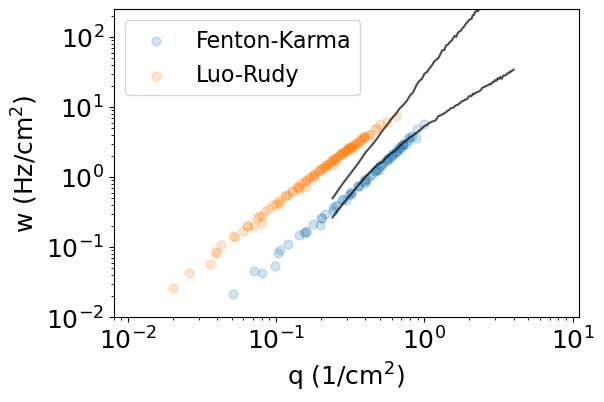

In [33]:
#plot the original annihilation rates
dict_wjr = recall_death_rates_vidmar_rappel()
fk=dict_wjr['fk']
lr=dict_wjr['lr']
figsize = (6, 4)  #(5,4)
fontsize=18
fig, ax = plt.subplots(figsize=figsize)
df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label='_Best Fit to FK')
df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label='_Best Fit to LR')
ax = plot_death_rates_loglog_full(fk,lr,ax=ax,fontsize=fontsize)
ax.legend(loc='upper left',fontsize=fontsize-2)
#add annotation
# xy=(0.3, 11)
# xytext=(0.09, 10)
#ax.annotate(r"best fit ($a>0$)", xy=xy, xytext=xytext,fontsize=fontsize)
#add marker showing the slope of ~2
# annotation.slope_marker(origin=(2.3, 2.0),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},
#                         ax=ax)
plt.show()
#reset

In [27]:
beep(3)



0

In [106]:
beep(4)



0

# scratchwerk

In [104]:
# # #compute the defects as rows for tables
# # use_generate_annihilation_defect_table=True
# # if use_generate_annihilation_defect_table:
# #     from dask.distributed import Client, progress
# #     client = Client(n_workers=4, threads_per_worker=1)
# #     print(client)
# #save the defects as a table (parquet is good)
# print(f"link to dask dashboard: {client.dashboard_link}")

In [102]:
# load_cache=False
# if load_cache:
#     pkl_dir_defects='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_defects_to_full.pkl' #~200MB
#     pdict=load_from_pickle(pkl_dir_defects)
#     num_trials = len(list(pdict.keys()))
#     print(f"loaded defects from {num_trials} trials.")

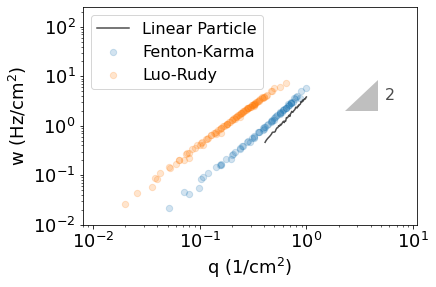

In [22]:
testing=True
#plot the original annihilation rates
dict_wjr = recall_death_rates_vidmar_rappel()
fk=dict_wjr['fk']
lr=dict_wjr['lr']
figsize = (6, 4)  #(5,4)
fontsize=18
if testing:
    #input_fn = task_lst[17]
    fig, ax = plt.subplots(figsize=figsize)
    df.plot(x='q',y='w',alpha=0.7,ax=ax,color='black',label='Linear Particle')
    ax = plot_death_rates_loglog_full(fk,lr,ax=ax,fontsize=fontsize)
    ax.legend(loc='upper left',fontsize=fontsize-2)
    #add annotation
    # xy=(0.3, 11)
    # xytext=(0.09, 10)
    #ax.annotate(r"best fit ($a>0$)", xy=xy, xytext=xytext,fontsize=fontsize)
    #add marker showing the slope of ~2
    annotation.slope_marker(origin=(2.3, 2.0),
                            slope=2,
                            text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
                            poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
                            ax=ax)
    plt.show()

In [120]:
# input_fn="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_all/job.out.23278799.122997"
# input_fn="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_all/job.out.23278799.142139"
# input_fn="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_all/job.out.23278799.135362"
# df,dict_linear = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)

# visually investigate the defects

# compute error/defect of a linear particle model annihilation rates wrt the full model

- DONE: Option 1: do it directly in a way that is impenetrable in argument
- DONT: Option 2: do it lazily by copying the solution which i already said is flawed to wjr during our last excellent meeting...
- DONE: evaluate over all such files

In [122]:
# def routine(task):
#     try:
#         input_fn = task
#         df,dict_linear = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
#         #dict_linear['folder'] = os.path.basename(input_fn) #strings are relatively expensive at these scales...
#         return dict_linear
#     except Exception as e:
#         return f"Warning: {e} for {task=}"

In [123]:
# use_evaluate_annihilation_defects=False
# if use_evaluate_annihilation_defects:
#     from dask.distributed import Client, progress
#     client = Client(n_workers=4, threads_per_worker=1)
#     client

In [124]:
# max_num_jobs=4
# printing=True
# saving=False
# #optionally, run daskbag
# os.chdir(nb_dir)
# npartitions=np.min((len(task_lst),max_num_jobs))
# if use_evaluate_annihilation_defects:
#     if printing:
#         print(f"running {len(task_lst)} tasks over {npartitions} cpu cores (140775 tasks over 4 cpu cores took <7.5 minutes)...")
#     retval=eval_routine_daskbag(routine,task_lst,npartitions,printing=printing)
#     if printing:
#         print(f"tasks complete!")
#     #format results
#     dict_linear_lst=[]
#     for rv in retval:
#         if type(rv)==type(''):
#             print(rv)
#         else:
#             dict_linear_lst.append(rv)
#     if saving:
#         #DONT: save the defects as a complicated hierarchical dataset
#         pkl_dir_defects=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_full.pkl'
#         pdict=dict(zip(range(len(dict_linear_lst)),dict_linear_lst))
#         save_to_pickle(pkl_dir_defects,pdict)
#         print(f"saved to\n{pkl_dir_defects=}")

# DONE: completed task list

In [ ]:
#DONE: (pre)compute w,q from the full model as a lookup table with linear lookups
#DONE: for each row in df,
##DONE: compute the squared error (se) to the FK model
##DONE: compute the squared error (se) to the LR model
#then,
#DONE: wrap ^this into a function from df,wjr to df
#DONE(later, if forloop is slow): daskbag over ^this for a disappointing speedup...
#DONT(later, if cpu is slow): make ^this into a cudf function?
##DONT(prereq): dev wjr_lookup_table from wjr, nah the raw data. looks undeniably like a powerlaw 
##DONT(prereq): test ^this works with Example Usage that computes the rmse to/from the FK/LR model (print a 2x2 matrix)
##DONT: dev chunker / generator / something that returns with yield or yield from.
##DONT: plug ^that into the identity function from df to df
##DONT: modify the identity function to add fields for se_fk and se_lr for each row using wjr_lookup_table

In [ ]:
# df_defects_lr.to_parquet? >>
# See Also
# --------
# read_parquet : Read a parquet file.
# DataFrame.to_csv : Write a csv file.
# DataFrame.to_sql : Write to a sql table.
# DataFrame.to_hdf : Write to hdf.

# DONT(later): dev analysis of powerfits

In [ ]:
# b = db.from_delayed([dask.delayed(range)(i) for i in [100000000] * 5])

In [ ]:
# printing=True
# if printing:
#     print(f"dict_linear contains the error of linear fit to full pair-annihilation rates:")
#     print_dict(dict_linear)
#     print(f"\npowerlaw data for the {model_str} model:")
#     print(f"{qlim_full=}")
#     print_dict(fit_full)

In [ ]:
# powerlaw_fit_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_all_powerlaw_fits.csv'
# df=pd.read_csv(powerlaw_fit_dir)
# print (f"{df.shape=}")
# df.head()

In [ ]:
# #DONE(preivously): plot given log-file result over the original annihilation rates
# #plot the best fits when a>0
# plt.plot(q_values_fk,what_values_fk,'--',c='C0',label=f'_Fit to FK',alpha=1,lw=2)
# plt.plot(q_values_lr,what_values_lr,'--',c='C1',label=f'_Fit to LR',alpha=1,lw=2)


In [ ]:
# use_loglog=True
# df.plot.scatter(x='q',y='w',alpha=0.7)
# format_plot(ax=plt.gca(),xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=18,use_loglog=use_loglog)
# plt.xlim([0.1,4])
# plt.ylim([0.1,100])
# # plt.xlim([0.1,1])
# # plt.ylim([0.1,800])
# plt.show()

In [ ]:
#DONT: use search_for_file() #demon function! avoid! crashes meh terminal cli!
#DONE: abstracted parsing of attractive output to .csv
# input_folder=f"../data"
# input_fn='example.log'
# os.chdir(input_folder)
# assert (os.path.exists(input_fn))
# df=parse_output_log(input_fn, include_inputs=False, printing=True)
#get last input_fn listed for run_num
